In [1]:
import pandas as pd
import numpy as np
import requests
import xmltodict
import urllib.request
import pprint
import json
import csv
np.set_printoptions(suppress=True) 
import pandas as pd

In [2]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance
from sklearn.metrics import r2_score

C:\Users\chosungsu\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
data = pd.read_csv('data_file_csv.csv', encoding='cp949')

In [4]:
#딕셔너리에 키 값을 대입해 벨류값을 얻어오는 함수
def get_value(k,dic):
    for key, value in dic.items():
         if k == key:
            return value
        
#string, float등 의사결정나무에서는 사용하기 힘든 변수를 사용할 수 있게끔 만들어주는 함수
def get_index(name):
    temp_list = data[name].tolist()
    temp_set = set(temp_list)
    temp_list2 = list(temp_set)
    dic= {string:i for i,string in enumerate(temp_list2)}
    
    for i in range(len(temp_list)):
        temp = data.loc[i,name]
        temp_value = get_value(temp,dic)
        data.loc[i,name] = temp_value
        
#여기서부터 srartpos1에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('startpos1')
    
#여기서부터 startpos2에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('startpos2')
    
#여기서부터 endpos2에 있는 string 값들을 전부 숫자로 바꿔주는 작업
get_index('endpos2')
data.drop(columns=["Unnamed: 0"],inplace=True)
data['startpos1'] = pd.to_numeric(data['startpos1'])
data['startpos2'] = pd.to_numeric(data['startpos2'])
# list로 만들기
list_whycall=data['whycall'].to_list()
list_gotoschool=data['gotoschool'].to_list()
list_gotocharge=data['gotocharge'].to_list()
# end_destination에 연산결과 추가하기
data['end_destination'] = 0
for i in range(len(list_whycall)):
    if (list_whycall[i] *100+ 
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 100) :
        data.iloc[i, 21] = 3
    elif (list_whycall[i] *100+ 
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 10) :
        data.iloc[i, 21] = 2
    elif (list_whycall[i] *100+ 
                           list_gotoschool[i]*10+
                           list_gotocharge[i] == 10) :
        data.iloc[i, 21] = 1
    else :
        data.iloc[i, 21] = 0
#변수 endlat과 endlon을 합치는 작업
te_list = data['startlat'].tolist()
for i in range (len(te_list)):
    data.loc[i,'startplus'] = ['1']

for i in range (len(te_list)):
    a = data.loc[i,'startlat']
    b = data.loc[i,'startlon']
    
    a = a * 10
    b = b * 10
    a = a % 100
    b = b % 100
    a = int(a)
    b = int(b)
    new = a*100 + b
    data.loc[i,'startplus'] = [new]
data.head()

,no,cartype,receipttime,settime,ridetime,startpos1,startpos2,endpos1,endpos2,receipt,...,startlat,startlon,endlat,endlon,whycall,gotoschool,gotocharge,endplus,end_destination,startplus
0,8075,중형 승합,2022-05-07 오전 12:08:21,2022-05-07 오전 12:15:19,2022-05-07 오전 12:30:26,24,278,동작구,279,2022/05/07 0:08,...,37.53,126.90,37.49,126.90,0,0,0,7469,0,7569
1,8231,중형승합,2022-05-07 오전 12:08:51,2022-05-07 오전 12:17:25,2022-05-07 오전 12:46:23,22,157,관악구,209,2022/05/07 0:08,...,37.50,126.88,37.47,126.97,0,0,0,7469,0,7568
2,8279,중형 승합,2022-05-07 오전 12:09:00,2022-05-07 오전 12:26:57,2022-05-07 오전 12:54:43,13,73,노원구,78,2022/05/07 0:09,...,37.67,127.08,37.64,127.07,0,0,0,7670,0,7670
3,1560,중형 승합,2022-05-07 오전 12:13:00,2022-05-07 오전 12:14:01,2022-05-07 오전 12:14:25,9,35,강동구,35,2022/05/07 0:13,...,37.59,127.08,37.54,127.13,0,0,0,7571,0,7570
4,7913,중형승합,2022-05-07 오전 12:18:00,2022-05-07 오전 1:15:54,2022-05-07 오전 1:33:16,9,87,동대문구,193,2022/05/07 0:18,...,37.61,127.09,37.57,127.06,0,0,0,7570,0,7670


In [5]:
x=np.array(data.loc[: ,['end_destination', 'startplus',
                        'receipt-ride','hour',
                         'startpos1', 'startpos2']])
y=data['endplus']
#  data train,test로 나누기
x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size=0.1, random_state=42, shuffle=False)

In [6]:
base_model = DecisionTreeRegressor(random_state=10)
ada_model = AdaBoostRegressor(
        base_estimator=base_model,
        n_estimators=1000,
        learning_rate=0.1).fit(x_train,y_train)
yte_pred=ada_model.predict(x_test)
ada_r2 = r2_score(y_test, yte_pred)
# AdaBoost 결과 MAE 확인
print('MAE: ', mean_absolute_error(y_test, yte_pred))
print("R2: %.2f" % ada_r2)

MAE:  18.33164518840781
R2: 0.45


In [7]:
rf_clf = RandomForestClassifier()
knn_data = KNeighborsClassifier(n_neighbors=5)
#  개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_data = VotingClassifier(estimators=[("RF", rf_clf), 
                                       ("KNN", knn_data)], voting="soft")
vo_final = vo_data.fit(x_train, y_train)
yte_pred = vo_data.predict(x_test)
vo_r2 = r2_score(y_test, yte_pred)
# VotingClassifier 결과 MAE 확인
print('MAE: ', mean_absolute_error(y_test, yte_pred))
print("R2: %.2f" % vo_r2)

MAE:  21.365384615384617
R2: 0.30


In [8]:
tic = time()
pipe = make_pipeline(QuantileTransformer(),
                     vo_data,
                     ada_model,
                    )
pipe.fit(x_train,y_train)
yte_pred = pipe.predict(x_test)
pipe_r2 = r2_score(y_test, yte_pred)
print("done in {:.3f}s".format(time()-tic))
# Pipeline 결과 MAE 확인
print('MAE: ', mean_absolute_error(y_test, yte_pred))
print("R2: %.2f" % pipe_r2)

done in 1.567s
MAE:  18.99767348036579
R2: 0.45


In [9]:
#x_names : x변수를 리스트화
x_names = ['end_destination', 'startplus',
                        'receipt-ride','hour',
                         'startpos1', 'startpos2']
# permuter 생성
permuter = PermutationImportance(
    pipe,
    scoring='neg_mean_absolute_error',
    n_iter=3,
    random_state=1)
# permutation importance 계산
permuter.fit(x_test, y_test)
# 결과 확인
feature_names = x_names
pd.Series(permuter.feature_importances_, 
          feature_names).sort_values(ascending=False)

startplus          13.382800
startpos2          13.285633
end_destination    11.565411
startpos1           7.307022
receipt-ride        6.535106
hour                0.815064
dtype: float64

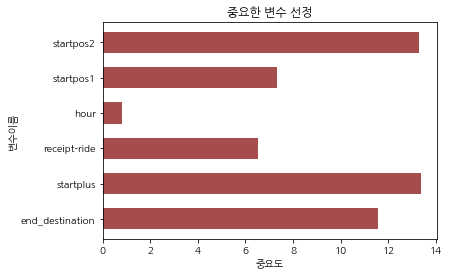

In [10]:
#위 결과를 바탕으로 그린 변수 중요도 파악용 바그래프(참고하세요)
plt.rc('font', family = 'NanumGothic')
plt.barh(feature_names, permuter.feature_importances_, 
        color='maroon', height = 0.6, align='center', alpha = 0.7)
plt.title('중요한 변수 선정')
plt.ylabel('변수이름')
plt.xlabel('중요도')
plt.show()